In [1]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import parse_correlations_dataframe as get_corr
import copy

In [2]:
# Download Cancers
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-b6f1e8b3506b>, line 6)


In [3]:
def find_norm_tumor_corr_effect(cancer_type, gene):
    tumor = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'tumor', flatten = True)
    normal = cancer_type.multi_join({'proteomics': gene, 'transcriptomics': gene}, tissue_type= 'normal', flatten = True)
    tumor = tumor.dropna()
    normal = normal.dropna()
    if len(normal) < 2 or len(tumor) < 2:
        return float("NaN"), float("NaN"), float("NaN")
    tumor.columns = ['proteomics', 'transcriptomics']
    normal.columns = ['proteomics', 'transcriptomics']
    groups = ['tumor'] * len(tumor)
    groups.extend(['normal']*len(normal))
    prot_list = list(tumor['proteomics'])
    prot_list.extend(list(normal['proteomics']))
    trans_list = list(tumor['transcriptomics'])
    trans_list.extend(list(normal['transcriptomics']))
    gene_df = pd.DataFrame({'Type': groups, 'Proteomics': prot_list, 'Transcriptomics': trans_list})
    is_tum = gene_df['Type'] == 'tumor'
    is_norm = gene_df['Type'] == 'normal'
    tum_cor, tum_pval = scipy.stats.pearsonr(gene_df[is_tum]['Proteomics'], gene_df[is_tum]['Transcriptomics'])
    norm_cor, norm_pval = scipy.stats.pearsonr(gene_df[is_norm]['Proteomics'], gene_df[is_norm]['Transcriptomics'])
    return tum_cor, norm_cor, gene_df  

In [4]:
def get_cancer_string(cancer):
    if cancer == ccrcc:
        return "ccrcc"
    if cancer == en:
        return 'endometrial'
    if cancer == luad:
        return 'luad'
    if cancer == hnscc:
        return 'hnscc'
    if cancer == lscc:
        return 'lscc'

In [5]:
cancer_genes = ['BRAF','FAT1','IDH1','TP53','KMT2D','KRAS','PIK3CA','PTEN','SPTA1']
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [6]:
# Make df for grid plot
dfs = []
for cancer in cancer_list:
    for gene in cancer_genes:
        if gene == "KRAS" and cancer == ccrcc:
            continue
        tum_cor, norm_cor, gene_df = find_norm_tumor_corr_effect(cancer, gene)
        if not np.isnan(tum_cor):
            gene_df['Cancer'] = [get_cancer_string(cancer)] * len(gene_df)
            gene_df['Gene'] = [gene] * len(gene_df)
            dfs.append(gene_df)
df = pd.concat(dfs)
df = df.rename(columns ={'Type': 'Tissue'})

cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You tried to flatten a column index that didn't have multiple levels, so we didn't actually change anything. (C:\Users\nanel\anaconda3\lib\site-packages\cptac\dataset.py, line 700)
cptac warning: You t

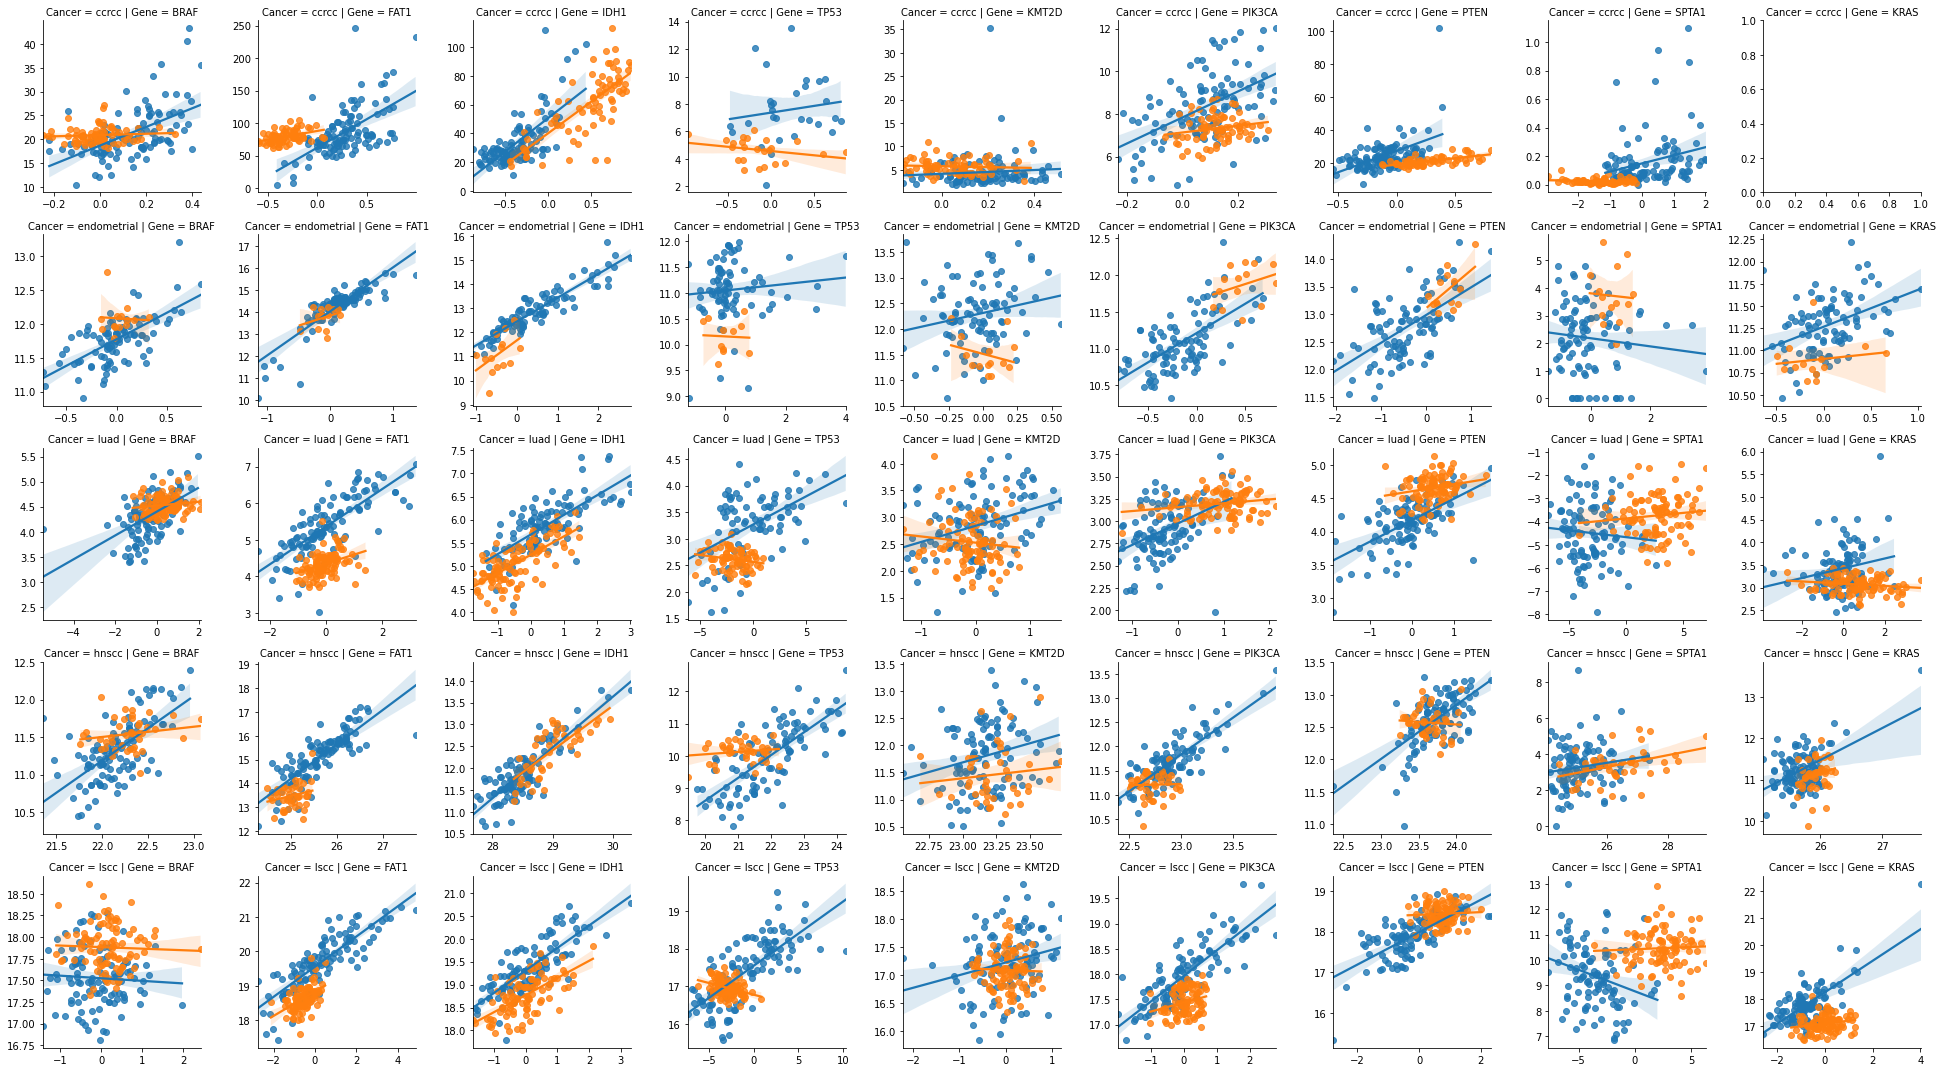

In [7]:
# Make grid plot of all
g = sns.FacetGrid(df, col = 'Gene', row = 'Cancer', hue = 'Tissue', sharex = False, sharey = False, legend_out= True)
g.map_dataframe(sns.regplot, y = 'Transcriptomics', x = 'Proteomics', fit_reg = True)
g.savefig('Figures/Figure 7 Individual gene correlations.png')